## Poisson Equation in 2D

In this example we solve the Poisson equation in two space dimensions.

For a domain $\Omega \subset \mathbb{R}^2$ with boundary $\partial \Omega = \Gamma_D \cup \Gamma_N$, we write the boundary value problem (BVP):

$$ 
\left\{
\begin{array}{ll}
- \Delta u = f  & \text{in} \; \Omega, \\
u = u_D & \text{on} \; \Gamma_D, \\
\nabla u \cdot \boldsymbol{n} = g & \text{on} \; \Gamma_N.
\end{array}
\right.$$

Here, $\Gamma_D \subset \Omega$ denotes the part of the boundary where we prescribe Dirichlet boundary conditions, and $\Gamma_N \subset \Omega$ denotes the part of the boundary where we prescribe Neumann boundary conditions. $\boldsymbol{n}$ denotes the unit normal of $\partial \Omega$ pointing outside $\Omega$. 

To obtain the weak form we define the functional spaces $V_{u_D} := \left\{ u \in H^1(\Omega) \, |\, u = u_D \text{ on } \Gamma_D \right\}$ and $V_{0} := \left\{ u \in H^1(\Omega) \, |\, u = 0 \text{ on } \Gamma_D \right\}$.
Then we multiply the strong form by an arbitrary function $v \in V_0$ and integrate over $\Omega$:

$$ - \int_\Omega \Delta u \, v \, dx = \int_\Omega f\,v \, dx, \quad \forall v \in V_0. $$

Integration by parts of the non-conforming term gives

$$ - \int_\Omega \Delta u \, v \, dx = \int_\Omega \nabla u \cdot \nabla v \, dx - \int_{\partial\Omega} (\nabla u \cdot \boldsymbol{n}) \,v\, ds $$

Recalling that $v = 0$ on $\Gamma_D$ and that $\nabla u \cdot \boldsymbol{n} = g$ on $\Gamma_N$, the weak form of the BVP is the following.

Find $u \in V_{u_D}$:
$$ \int_\Omega \nabla u \cdot \nabla v \, dx = \int_\Omega f\,v \, dx + \int_{\Gamma_N} g\,v\,ds, \quad \forall v \in V_0. $$

To obtain the finite element discretization we then introduce a triangulation (mesh) $\mathcal{T}_h$ of the domain $\Omega$ and we define a finite dimensional subspace $V_h \subset H^1(\Omega)$ consisting of globally continuous functions that are piecewise polynomial on each element of $\mathcal{T}_h$.

By letting $V_{h, u_D} := \{ v_h \in V_h \,|\, v_h = u_D \text{ on } \Gamma_D\}$ and $V_{h, 0} := \{ v_h \in V_h \,|\, v_h = 0 \text{ on } \Gamma_D\}$, the finite element method then reads:

Find $u_h \in V_{h, u_D}$ such that:
$$ \int_\Omega \nabla u_h \cdot \nabla v_h \, dx = \int_\Omega f\,v_h \, dx + \int_{\Gamma_N} g\,v_h\,ds, \quad \forall v_h \in V_{h,0}. $$

In what follow, we will let $\Omega := [0,1]\times[0,1]$ be the unit square, $\Gamma_N := \{ (x,y) \in \partial\Omega \,|\, y = 1\}$ be the top boundary, and $\Gamma_D := \partial\Omega \setminus \Gamma_N$ be the union of the left, bottom, and right boundaries.

The coefficient $f$, $g$, $u_D$ are chosen such that the analytical solution is $u_{ex} = e^{\pi y} \sin(\pi x)$.


### 1. Imports
We import the following Python packages:

- `dolfinx` is the python interface to FEniCSx.
- `ufl` is the python interface used to define variational forms in FEniCSx.
- `matplotlib` is a plotting library that produces figure similar to the Matlab ones.
- `numpy` is a built-in Python library of mathematical functions.

In [2]:
# Import FEniCSx
import dolfinx as dl
import ufl

from mpi4py import MPI
from petsc4py import PETSc

# Import the package of mathematical functions
import math
import numpy as np
# Enable plotting inside the notebook
import matplotlib.pyplot as plt
import pyvista as pv
pv.set_jupyter_backend('static')

### 2. Define the mesh and the finite element space
We define a triangulation (mesh) of the unit square $\Omega = [0,1]\times[0,1]$ with `n` elements in each direction. The mesh size $h$ is $\frac{1}{n}$.

We also define the finite element space $V_h$ as the space of globally continuos functions that are piecewise polinomial (of degree $d$) on the elements of the mesh.

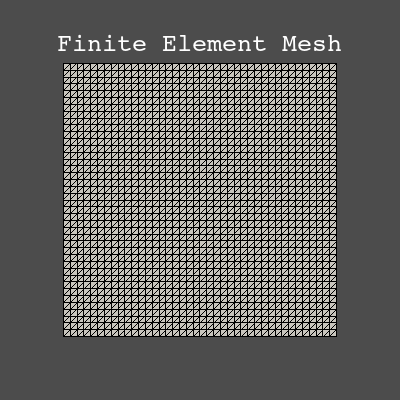

Number of dofs 1681


In [3]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nprocs = comm.Get_size()
iAmRoot = rank == 0
# Define the finite element mesh. The mesh size h is 1/nx
nx = 40
ny = nx
    
mesh = dl.mesh.create_unit_square(comm, nx, ny, dl.mesh.CellType.triangle)
cells, types, coords = dl.plot.create_vtk_mesh(mesh, mesh.topology.dim)
grid = pv.UnstructuredGrid(cells, types, coords)

# Create plotter
window_size=[400,400]
plotter = pv.Plotter(window_size=window_size)
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.add_title('Finite Element Mesh', font='courier', color='w',
                   font_size=10)
plotter.show()

# Define the finite element space V_h as the space of piecewise linear functions on the elements of the mesh.
degree = 1
Vh = dl.fem.FunctionSpace(mesh, ("CG", degree))
Vhp = dl.fem.FunctionSpace(mesh, ("CG", degree+2))
u  = dl.fem.Function(Vh)

print("Number of dofs", u.vector.size)

### 3. Define the Dirichlet boundary condition

We define the Dirichlet boundary condition $u = u_d := \sin(\pi x)$ on $\Gamma_D$.

In [4]:
u_bc = dl.fem.Function(Vh)
u_bc.interpolate(lambda x: np.exp(np.pi * x[1]) * np.sin(np.pi * x[0]))


# --- interpolate the expression ---

facet_dim = mesh.topology.dim-1
facets_D = dl.mesh.locate_entities_boundary(mesh, dim=facet_dim, \
                                        marker=lambda x: np.logical_or(np.isclose(x[0], 0.0), \
                                        np.logical_or(np.isclose(x[1], 0.0), np.isclose(x[0], 1.0))))
dofs_D = dl.fem.locate_dofs_topological(V=Vh, entity_dim=facet_dim, entities=facets_D)


bcs = [dl.fem.dirichletbc(u_bc, dofs_D)]

### 4. Define the variational problem

We write the variational problem $a(u_h, v_h) = F(v_h)$. Here, the bilinear form $a$ and the linear form $L$ are defined as

- $a(u_h, v_h) := \int_\Omega \nabla u_h \cdot \nabla v_h \, dx$
- $L(v_h) := \int_\Omega f v_h \, dx + \int_{\Gamma_N} g \, v_h \, dx$.

$u_h$ denotes the trial function and $v_h$ denotes the test function.  The coefficients $f = 0$ and $g = \pi\, e^{\pi y} \sin( \pi x) $ are also given.

In [7]:
uh = ufl.TrialFunction(Vh)
vh = ufl.TestFunction(Vh)

f = dl.fem.Constant(mesh, PETSc.ScalarType(0.))


g = dl.fem.Function(Vhp)
g.interpolate(lambda x: np.pi * np.exp(np.pi)* np.sin(np.pi*x[0]))

A_expr = ufl.inner(ufl.grad(uh), ufl.grad(vh)) * ufl.dx
b_expr = f * vh * ufl.dx + g * vh * ufl.ds

### 5. Assemble and solve the finite element discrete problem

We now assemble the finite element stiffness matrix $A$ and the right hand side vector $b$. Dirichlet boundary conditions are applied at the end of the finite element assembly procedure and before solving the resulting linear system of equations.

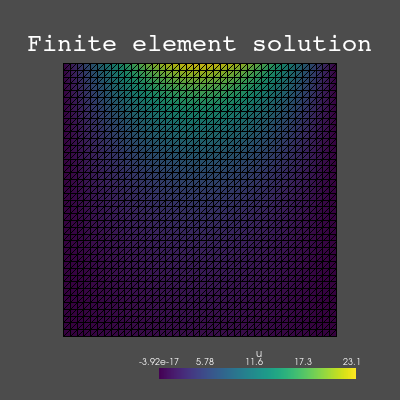

In [8]:
problem = dl.fem.petsc.LinearProblem(A_expr, b_expr, u=u, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
problem.solve()

grid.point_data["u"] = u.x.array.real


plotter = pv.Plotter(window_size=window_size)
plotter.add_mesh(grid, show_edges=True, show_scalar_bar=True, scalars="u")
plotter.view_xy()
plotter.add_title('Finite element solution', font='courier', color='w',
                     font_size=10)
plotter.show()

### 6. Compute error norms

We then compute the $L^2(\Omega)$ and the energy norm of the difference between the exact solution and the finite element approximation.

In [9]:
u_ex = dl.fem.Function(Vhp)
u_ex.interpolate(lambda x: np.exp(np.pi*x[1]) * np.sin(np.pi*x[0]))

loc_err_L2 = dl.fem.assemble_scalar(dl.fem.form((u_ex-u)**2 * ufl.dx))
err_L2  = np.sqrt(mesh.comm.allreduce(loc_err_L2, op=MPI.SUM))
loc_norm_ex_L2 = dl.fem.assemble_scalar(dl.fem.form(u_ex**2 * ufl.dx))
norm_ex_L2 = np.sqrt(mesh.comm.allreduce(loc_norm_ex_L2, op=MPI.SUM))

loc_err_energy = dl.fem.assemble_scalar(dl.fem.form(ufl.inner(ufl.grad(u) - ufl.grad(u_ex), ufl.grad(u) - ufl.grad(u_ex)) * ufl.dx))
err_energy = np.sqrt(mesh.comm.allreduce(loc_err_energy, op=MPI.SUM))
loc_norm_ex_energy = dl.fem.assemble_scalar(dl.fem.form(ufl.inner(ufl.grad(u_ex), ufl.grad(u_ex)) * ufl.dx))
norm_ex_energy = np.sqrt(mesh.comm.allreduce(loc_norm_ex_energy, op=MPI.SUM))


if iAmRoot:
    print("|| u_h - u_ex ||_L^2 / || u_ex ||_L^2 = {0:1.2e}".format(err_L2 / norm_ex_L2) )
    print( "|| u_h - u_ex ||_e / || u_ex ||_e = {0:1.2e}".format(err_energy / norm_ex_energy) )

|| u_h - u_ex ||_L^2 / || u_ex ||_L^2 = 1.09e-03
|| u_h - u_ex ||_e / || u_ex ||_e = 3.92e-02
